# Demo object and attribute predictions


### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

/home/ltkhiem/anaconda3/envs/bottomup/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


* Load `caffe`.

In [2]:
# Change dir to caffe root or prototxt database paths won't work wrong
import os
print os.getcwd()
os.chdir('..')
print os.getcwd()

/home/ltkhiem/source/bottom-up-attention/tools
/home/ltkhiem/source/bottom-up-attention


In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
sys.path.insert(0, './caffe/python/')
sys.path.insert(0, './lib/')
sys.path.insert(0, './tools/')

import caffe

In [4]:
data_path = './data/genome/1600-400-20'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [5]:
# Check object extraction
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect,_get_blobs
from fast_rcnn.nms_wrapper import nms
import cv2

GPU_ID = 0   # if we have multiple GPUs, pick one 
caffe.set_device(GPU_ID)  
caffe.set_mode_gpu()
net = None
cfg_from_file('experiments/cfgs/faster_rcnn_end2end_resnet.yml')


./lib/fast_rcnn/config.py:288: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [6]:

weights = 'data/faster_rcnn_models/resnet101_faster_rcnn_final.caffemodel'
prototxt = 'models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'



In [7]:
net = caffe.Net(prototxt, caffe.TEST, weights=weights)

./lib/rpn/proposal_layer.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  layer_params = yaml.load(self.param_str)


boxes=12


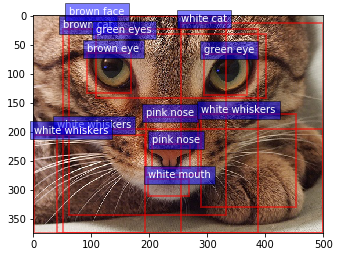

In [88]:

im_file = 'data/demo/000542.jpg'

###########################
# Similar to get_detections_from_im
conf_thresh=0.4
min_boxes=10
max_boxes=30

im = cv2.imread(im_file)
scores, boxes, attr_scores, rel_scores = im_detect(net, im)

# Keep the original boxes, don't worry about the regression bbox outputs
rois = net.blobs['rois'].data.copy()
# unscale back to raw image space
blobs, im_scales = _get_blobs(im, None)

cls_boxes = rois[:, 1:5] / im_scales[0]
cls_prob = net.blobs['cls_prob'].data
attr_prob = net.blobs['attr_prob'].data
pool5 = net.blobs['pool5_flat'].data

# Keep only the best detections
max_conf = np.zeros((rois.shape[0]))
for cls_ind in range(1,cls_prob.shape[1]):
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
    keep = np.array(nms(dets, cfg.TEST.NMS))
    max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

keep_boxes = np.where(max_conf >= conf_thresh)[0]
if len(keep_boxes) < min_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
elif len(keep_boxes) > max_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]
############################

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

boxes = cls_boxes[keep_boxes]
objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)

for i in range(len(keep_boxes)):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print 'boxes=%d' % (len(keep_boxes))

In [22]:
cls_boxes.shape

(138, 4)

In [26]:
attr = np.argmax(attr_prob[:][:,1:], axis=1)
attr.shape

(138,)

In [27]:
attr

array([ 23,  23,  23,  23,   7,  23,   7,  23,  23,   7,   7,  23,  23,
         7,   7,  23,   7,  23,  23,  23,  23,   7,  23,  23,  23,   7,
         7,   7,  23,   8,   9,   7,   9,  23,   8,   7,  23,   7,   7,
        23,   7,   8,   7,   7,   9,   9,   7,  23,   7,   9,   7,   7,
         7,   7,  23,   7,   7,   7,   7,   8,   7,  23,   7,  23,  23,
         7,   7,   7,  23,   7,   7,   7,   9,   8,  23,   7,   8,   9,
         7,   7,  23,   7,   7,   7,   7,   7,   8,  23,   8,   7,   7,
         8,   7,   7,  23,   7,  23,   7,  23,   7,  23,   8,  23,   7,
         7,   7, 196,   7,   9,   8,   7,   7,  23,   7, 196,   7,  23,
        23,   7,   7,  11,   7,   7,  23,   7,  23,   8,   8,  23,   7,
         8,   7, 196,   7,   8,   7,  23,   7])

In [29]:
scores.shape

(138, 1601)

In [61]:
scores[137][np.argmax(scores[137])]

0.89560366

In [66]:
cls_scores

array([1.06844402e-06, 4.70126082e-07, 2.29467076e-07, 3.65124691e-07,
       5.56589896e-07, 3.63836534e-07, 6.16307290e-08, 1.87190508e-07,
       7.37799610e-07, 1.35033913e-08, 2.47868019e-08, 3.83087894e-07,
       2.27375850e-07, 1.26747565e-07, 2.01426076e-08, 7.99492668e-08,
       6.56075301e-08, 1.04172805e-07, 4.89825425e-07, 1.19267881e-07,
       1.01046446e-07, 6.24065066e-08, 1.00297541e-07, 4.43072878e-07,
       6.67210287e-08, 7.15000468e-08, 8.68586625e-08, 3.68763367e-08,
       1.13477036e-07, 5.18341324e-07, 2.31762755e-07, 8.34146352e-09,
       1.74077385e-07, 7.41114690e-08, 8.36829713e-07, 3.15635340e-08,
       2.96208249e-08, 3.57950292e-08, 2.49889240e-07, 1.19746105e-07,
       2.53491770e-08, 1.52906989e-06, 1.48598343e-08, 2.49981355e-07,
       2.38351248e-07, 2.60297156e-07, 1.14603118e-07, 1.66376097e-07,
       1.33545299e-07, 2.27049952e-07, 5.72738408e-08, 1.77404416e-07,
       2.44679583e-08, 2.31625386e-08, 6.00605574e-08, 8.40084837e-08,
      

In [74]:
max_conf

array([2.38253130e-03, 9.56297666e-03, 4.89431381e-01, 1.18621938e-04,
       2.19233688e-02, 1.61589423e-06, 1.95330987e-03, 1.03317188e-05,
       1.95803377e-03, 0.00000000e+00, 9.55244780e-01, 1.22664683e-01,
       1.08598925e-01, 1.67170856e-02, 5.47700483e-06, 2.89405784e-06,
       7.07373202e-01, 8.37428588e-03, 1.61527079e-02, 4.38482407e-03,
       5.64105110e-03, 5.44692436e-03, 0.00000000e+00, 3.03760260e-01,
       0.00000000e+00, 3.08243185e-03, 1.81051996e-03, 4.06404113e-04,
       6.10082468e-04, 0.00000000e+00, 9.71848011e-01, 0.00000000e+00,
       5.27796149e-03, 6.59164608e-01, 0.00000000e+00, 6.86503015e-03,
       3.50739574e-03, 5.51064149e-04, 1.31885130e-02, 5.87398484e-02,
       1.31697701e-02, 2.86878459e-03, 2.63698137e-04, 1.90932793e-03,
       1.67282240e-03, 8.36346745e-01, 4.82842699e-02, 7.29783950e-03,
       6.10422939e-02, 0.00000000e+00, 6.79396617e-05, 6.50050724e-03,
       1.76583212e-02, 9.84143279e-03, 1.13362717e-02, 4.59107978e-04,
      

In [86]:
np.where(max_conf >= conf_thresh)[0]

array([  2,  10,  16,  23,  30,  33,  45,  83,  85,  91,  94, 106, 107,
       119, 126])

In [78]:
max_conf[16]

0.7073732018470764

In [89]:
max_conf[keep_boxes]

array([0.48943138, 0.95524478, 0.7073732 , 0.97184801, 0.65916461,
       0.83634675, 0.59680521, 0.98471963, 0.84668559, 0.88610423,
       0.88291961, 0.97440672])

In [98]:
det_score = max_conf[keep_boxes]
det_result = []
for i in range(len(keep_boxes)):
    res = dict()
    bbox = boxes[i]
    res["bbox"] = bbox.tolist()
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
    res["class"] = cls
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
        res["attribute"] = attributes[attr[i]+1]
    res["score"] = det_score[i]
    det_result.append(res)

In [99]:
det_result

[{'attribute': 'brown',
  'bbox': [51.38998031616211, 22.77240753173828, 386.3478698730469, 374.375],
  'class': 'cat',
  'score': 0.48943138122558594},
 {'attribute': 'white',
  'bbox': [39.997825622558594, 195.24974060058594, 499.375, 374.375],
  'class': 'whiskers',
  'score': 0.955244779586792},
 {'attribute': 'white',
  'bbox': [254.4741668701172, 12.662315368652344, 499.375, 374.375],
  'class': 'cat',
  'score': 0.7073732018470764},
 {'attribute': 'pink',
  'bbox': [204.67918395996094,
   221.2259521484375,
   269.2214050292969,
   262.95361328125],
  'class': 'nose',
  'score': 0.9718480110168457},
 {'attribute': 'brown',
  'bbox': [61.53219223022461, 1.0, 331.7204895019531, 343.2347106933594],
  'class': 'face',
  'score': 0.6591646075248718},
 {'attribute': 'pink',
  'bbox': [193.20712280273438,
   174.44400024414062,
   284.19134521484375,
   275.4088134765625],
  'class': 'nose',
  'score': 0.8363467454910278},
 {'attribute': 'white',
  'bbox': [197.99005126953125,
   281.6

In [100]:
import json

In [106]:
with open("data_file.json", "w") as write_file:
    json.dump(det_result, write_file, indent=4)